In [20]:
from avaframe.in2Trans.rasterUtils import readRaster
from pathlib import Path
import os
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Polygon
import json
import numpy as np
import hashlib
import subprocess

from matplotlib.path import Path as mplPath
from matplotlib.colors import ListedColormap
from avaframe.in2Trans.shpConversion import SHP2Array
from matplotlib import colors
import pandas as pd
import pickle

from com1DFAUtils import *
from configobj import ConfigObj

domainWidth = {
    "avaMal": 1200
}

%load_ext autoreload
%autoreload 2

sim_case = "avaInclinedPlane"
avaframe_dir = Path(r"C:\git\snow_avalanches\AvaFrame\avaframe")
avaframe_data_dir = avaframe_dir / "data"
webigeo_app_dir = Path(r"C:\git\webigeo\cmake-build-release-visual-studio")

webigeo_input_dir = Path.cwd() / "webigeo_input"
webigeo_output_dir = Path.cwd() / "webigeo_output" 
webigeo_sim_dir = webigeo_output_dir / sim_case
sim_case_dir = avaframe_data_dir / sim_case
avaframe_input_dir = sim_case_dir / "Inputs"
avaframe_output_dir = sim_case_dir / "Outputs" / "com1DFA"
webigeo_to_avaframe_output_dir = sim_case_dir / "Outputs" / "webigeo"
avaframe_output_peak_dir = avaframe_output_dir / "peakFiles"
release_path = avaframe_input_dir / "REL"
release_scenerios = [file.replace(".shp", "") for file in os.listdir(release_path) if file.endswith(".shp")]
print("Release scenarios:", release_scenerios)



dem_header, dem = get_dem(avaframe_input_dir)
y = np.arange(0, dem_header["nrows"] * dem_header["cellsize"],  dem_header["cellsize"]) + dem_header["yllcenter"]
x = np.arange(0, dem_header["ncols"] * dem_header["cellsize"],  dem_header["cellsize"]) + dem_header["xllcenter"]
xx, yy = np.meshgrid(x, y)

    
# np.nan_to_num

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Release scenarios: ['release1IP']


In [21]:
# prepare simulations

randoms = np.arange(0, 1.0, 0.1)
persistences = np.arange(0, 1.0, 0.1)

for release_scenerio in release_scenerios:
    release_areas = get_release_areas(release_path / (release_scenerio + ".shp"))
    input_path =  webigeo_input_dir / sim_case / release_scenerio
    webigeo_export_release_points_path = input_path / "release_points"
    webigeo_export_dem_path = input_path / "heights"
    os.makedirs(input_path, exist_ok=True)
    os.makedirs(webigeo_export_release_points_path, exist_ok=True)
    os.makedirs(webigeo_export_dem_path, exist_ok=True)
    export_webigeo_release_points(webigeo_export_release_points_path, xx, yy, release_areas)
    corrected_dem = dem_np_to_webigeo(webigeo_export_dem_path, dem_header, dem)
    for random_contribution in randoms:
        for persistence in persistences:
            export_webigeo_settings(input_path, webigeo_output_dir / sim_case / release_scenerio, 
                                    random_contribution=random_contribution, 
                                    persistence=persistence, 
                                    num_paths_per_release_cell=256, 
                                    num_steps=2048)
    

No projection layer for shp file C:\git\snow_avalanches\AvaFrame\avaframe\data\avaInclinedPlane\Inputs\REL\release1IP.shp


DEM: (401, 1001) 401401
Release pixels: 3245


(<Figure size 2000x1000 with 1 Axes>,
 <Axes: title={'center': 'Visualization of DEM and release areas'}, xlabel='x (m)', ylabel='y (m)'>)

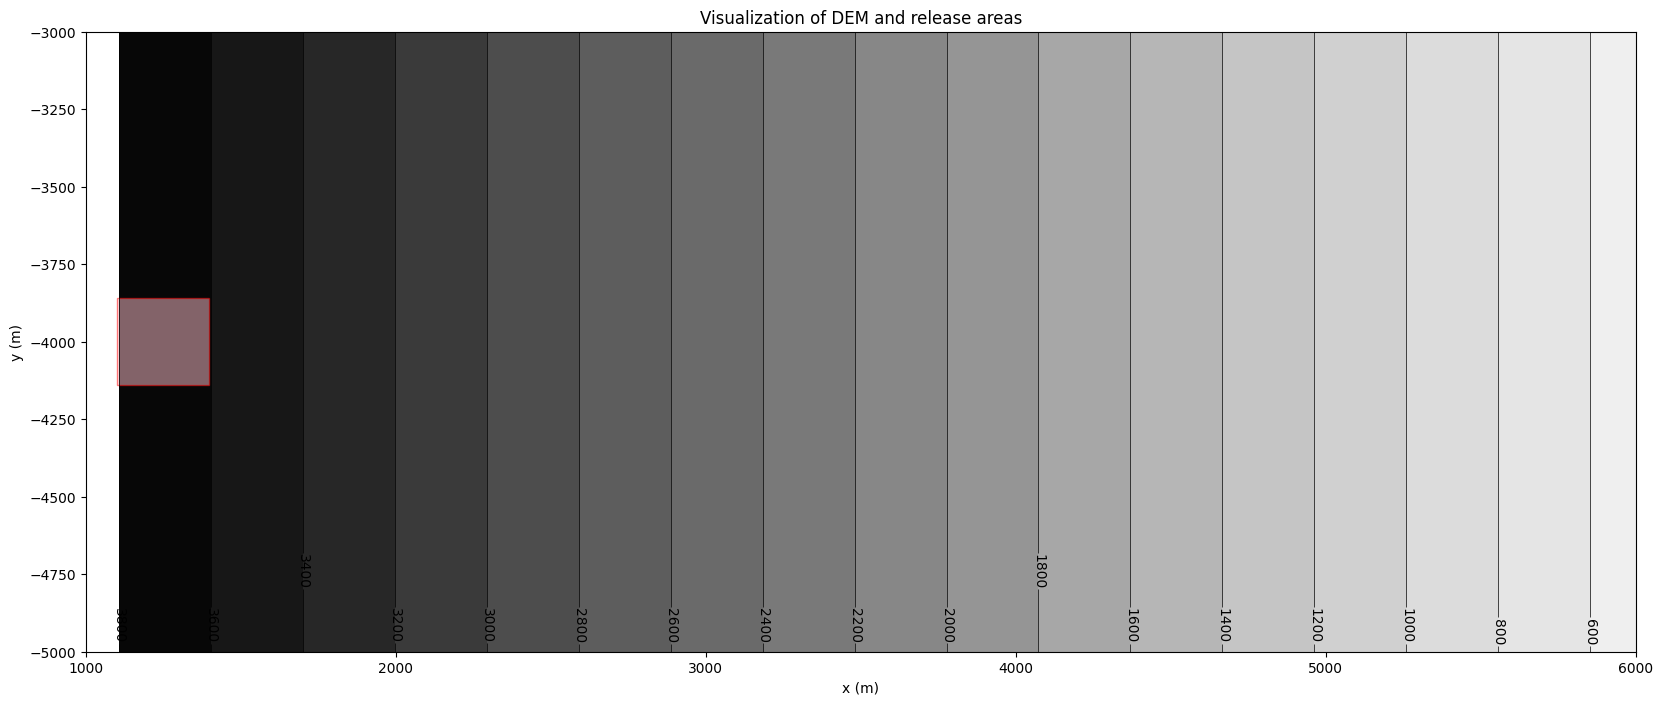

In [22]:
plot_inputs(xx, yy, corrected_dem, release_areas)

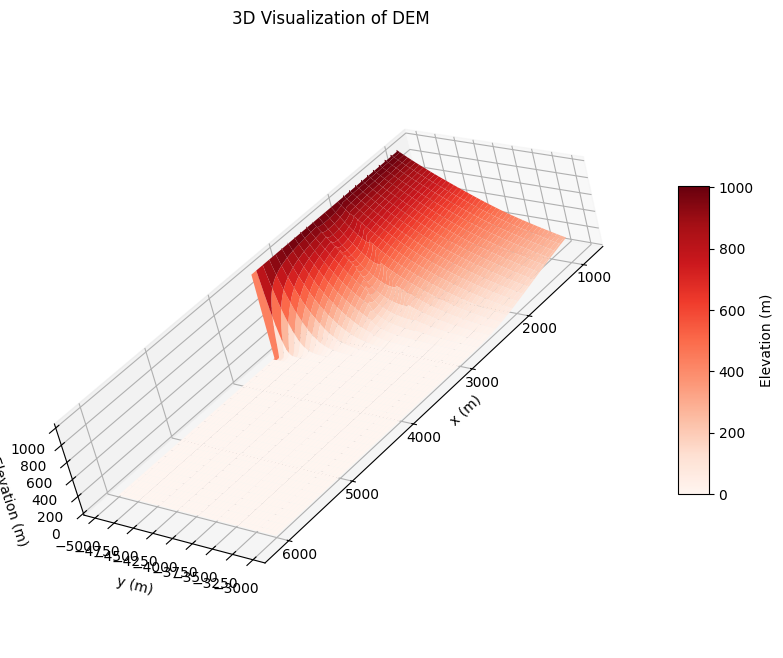

In [3]:
fig, ax = plot_dem_3d(xx, yy, dem)
ax.view_init(elev=30, azim=45, roll=15)

In [186]:
# run all simulations
import subprocess
eval_app = r"C:\git\webigeo\cmake-build-release-visual-studio\webigeo_eval.exe"
for test_case in os.listdir(webigeo_input_dir):
    for file in os.listdir(webigeo_input_dir / test_case):
        if file.startswith("settings") and file.endswith(".json"):
            settings_file = webigeo_input_dir / test_case / file
            print("Running Webigeo with settings file: ", settings_file)
            result = subprocess.run([eval_app, settings_file], capture_output=True, text=True)

            # Print the output
            print("STDOUT:")
            print(result.stdout)

            print("STDERR:")
            print(result.stderr)

            print("Return Code:", result.returncode)


Running Webigeo with settings file:  c:\git\evaluation-utilities\webigeo_input\avaHelixChannel_release1HX\settings_072a55_pers_0.50_rand_0.70_n_256_s_2048_a_25.json
STDOUT:
11:50:02 | Debug    | Creating WebGPU instance...
11:50:02 | Debug    | Dawn toggles: "allow_unsafe_apis"
11:50:02 | Info     | Got instance:  0x2070e415630
11:50:02 | Debug    | Requesting adapter...
11:50:02 | Info     | Got adapter:  0x2070e3dd950
11:50:02 | Debug    | Requesting device...
11:50:02 | Info     | Got device:  0x2070e446f70
11:50:03 | Debug    | running node graph ...
11:50:03 | Debug    | running LoadTextureNode ...
11:50:03 | Debug    | loading texture from  "c:\\git\\evaluation-utilities\\webigeo_input\\avaHelixChannel_release1HX\\release_points\\texture.png"
11:50:03 | Debug    |  node execution took  9 ms
11:50:03 | Debug    | running LoadTextureNode ...
11:50:03 | Debug    | loading texture from  "c:\\git\\evaluation-utilities\\webigeo_input\\avaHelixChannel_release1HX\\heights\\texture.png"
1

In [189]:
files = [file for file in os.listdir(avaframe_output_peak_dir) if file.endswith("pfv.asc") if file.find("null") != -1 if file.find("webigeo") == -1]
print(avaframe_output_dir)
print(files)
flow_velocity_file = avaframe_output_peak_dir / files[0]
dfa_flow_velocity = np.zeros_like(dem)
flow_velocity = readRaster(flow_velocity_file, noDataToNan=True)
flow_velocity_header = flow_velocity["header"]
flow_velocity = flow_velocity["rasterData"]
dfa_flow_velocity[:flow_velocity.shape[0], :flow_velocity.shape[1]] = flow_velocity


C:\git\snow_avalanches\AvaFrame\avaframe\data\avaHelix\Outputs\com1DFA
['release1HX_f0c368a886_C_L_null_dfa_pfv.asc']


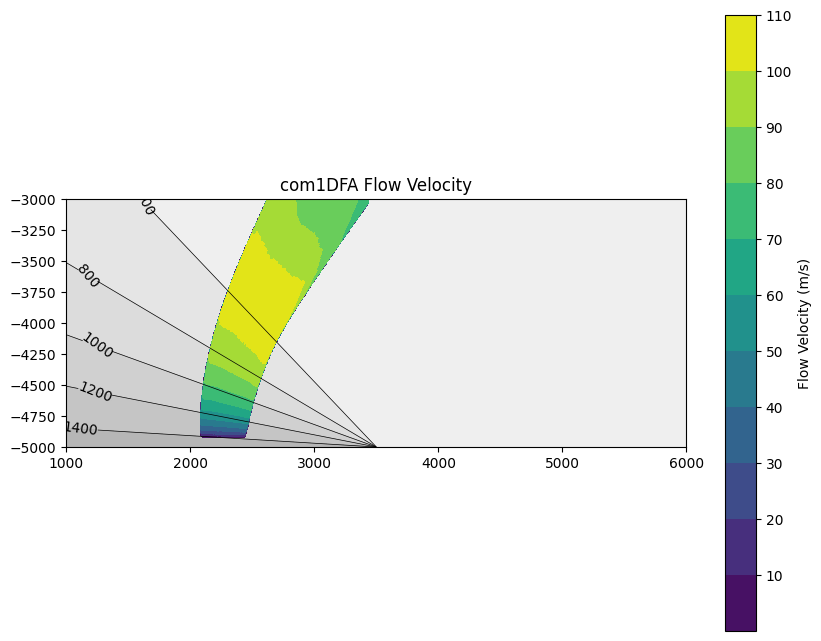

In [190]:

plot_flow_velocity(dfa_flow_velocity, corrected_dem, xx, yy, title="com1DFA Flow Velocity");

In [ ]:
# preparing AIMEC 
for release_scenerio in release_scenerios:
    d = webigeo_output_dir / sim_case / release_scenerio
    sim_cases = [s for s in os.listdir(d) if s != "plots"]

    for case in sim_cases:
        webigeo_hash = case.split("_")[0]

        header = f"""ncols {dem_header["ncols"]}
        nrows {dem_header["nrows"]}
        xllcenter {dem_header["xllcenter"]}
        yllcenter {dem_header["yllcenter"]}
        cellsize {dem_header["cellsize"]}
        nodata_value nan"""

        os.makedirs(avaframe_output_peak_dir, exist_ok=True)
        velocity = read_webigeo_flow_velocity(d / case / r"trajectories\texture_layer1_zdelta.png")
        np.savetxt(d / case / "flow_velocity_pfv.asc", np.flipud(velocity), header=header, comments='', fmt="%.16f")

        np.savetxt(avaframe_output_peak_dir / f"{release_scenerio}_{webigeo_hash}_D_L_null_webigeo_pfv.asc", np.flipud(velocity), header=header, comments='', fmt="%.16f")

        mass_file = [f for f in Path(avaframe_output_dir).glob(f"mass_{release_scenerio}*.txt")][0]
        dfa_hash = mass_file.name.split("_")[2]
        config_file = [f for f in Path(avaframe_output_dir / "configurationFiles").glob(f"{release_scenerio}_{dfa_hash}*.ini")][0]
        with open(avaframe_output_dir / "configurationFiles" / config_file) as file:
            data = file.read()
        data = data.replace("modelType = dfa", "modelType = webigeo")
        with open(avaframe_output_dir / "configurationFiles" / f"{release_scenerio}_{webigeo_hash}_D_L_null_webigeo.ini", "w") as file:
            file.write(data)


C:\Users\magge\AppData\Local\Temp\ipykernel_34304\2831850138.py:239: RuntimeWarning: invalid value encountered in sqrt
  return np.nan_to_num(np.sqrt(clamped_pixel * 2 * 9.81))


In [ ]:


file_path = str(avaframe_dir / "local_avaframeCfg.ini")
config = ConfigObj(file_path)
config["MAIN"]["avalancheDir"] = "data/" + sim_case
config.write()
with open(file_path, "r") as file:
    data = file.read()
with open(file_path, "w") as file:
    file.write(data.replace('""', ""))

dfa_hash = ""
for file in os.listdir(avaframe_data_dir / sim_case / "Outputs/com1DFA"):
    if file.endswith(".csv"):
        dfa_hash = file.split("_")[1].replace(".csv", "")
        break   
print(dfa_hash)
file_path = str(avaframe_dir / "ana3AIMEC/local_ana3AIMECCfg.ini")
config = ConfigObj(file_path, encoding="utf-8")
config["AIMECSETUP"]["referenceSimName"] = dfa_hash
config["AIMECSETUP"]["domainWidth"] = domainWidth.get(sim_case, 600)
config.write()
with open(file_path, "r") as file:
    data = file.read()
with open(file_path, "w") as file:
    file.write(data.replace('""', ""))

f0c368a886


In [193]:
# run aimec
old_wd = os.getcwd()
os.chdir(avaframe_dir)
result = subprocess.run([r"C:\git\snow_avalanches\venv\Scripts\python.exe", avaframe_dir / "runScripts" / "runAna3AIMEC.py "], capture_output=True, text=True)
# Print the output
print("STDOUT:")
print(result.stdout)

print("STDERR:")
print(result.stderr)

print("Return Code:", result.returncode)

os.chdir(old_wd)

STDOUT:
17352, 34956 - logUtils - INFO - Started logging at: 20250509_21h32m32s
17352, 34956 - logUtils - INFO - Also logging to: data\avaHelix\runAna3AIMEC_20250509_21h32m32s.log
17352, 34956 - logUtils - INFO - AvaFrame Version: 1.12+1.g1a72524c
17352, 34956 - runAna3AIMEC - INFO - MAIN SCRIPT
17352, 34956 - runAna3AIMEC - INFO - Current avalanche: data/avaHelix
17352, 34956 - cfgUtils - INFO - Reading config from: C:\git\snow_avalanches\AvaFrame\avaframe\ana3AIMEC\ana3AIMECCfg.ini and C:\git\snow_avalanches\AvaFrame\avaframe\ana3AIMEC\local_ana3AIMECCfg.ini
17352, 34956 - cfgUtils - INFO - Comparing two configs
17352, 34956 - cfgUtils - INFO - {'AIMECSETUP': {'domainWidth': '600',
17352, 34956 - cfgUtils - INFO -                 'cellSizeSL': '',
17352, 34956 - cfgUtils - INFO -                 'defineRunoutArea': 'False',
17352, 34956 - cfgUtils - INFO -                 'startOfRunoutAreaAngle': '10',
17352, 34956 - cfgUtils - INFO -                 'resTypes': '',
17352, 34956 - c

In [11]:

def load_aimec_csv(file_name):
    df = pd.read_csv(file_name)
    df["roc_distance"] = np.sqrt((1 - df["TP"])**2 + (df["FP"])**2)
    df = df.sort_values(by="roc_distance", ascending=True)[1:].reset_index(drop=True)
    return df

In [19]:
for release_scenerio in release_scenerios:
    d = webigeo_output_dir / sim_case / release_scenerio
    sim_cases = [s for s in os.listdir(d) if s != "plots"]
    file_name = avaframe_data_dir / sim_case / "Outputs" / "ana3AIMEC" / "com1DFA" / f"Results_{sim_case}_pfv_lim_1_w_{domainWidth.get(sim_case, 600)}resAnalysisDF.csv"
    print(file_name)
    df = load_aimec_csv(file_name)
    persistences = []
    randoms = []
    n_trajectories = []
    alphas = []
    for release_scenerio in release_scenerios:
        for i, hash in enumerate(df.simHash):
                print(hash)
                case = next((c for c in sim_cases if c.startswith(hash)))

                settings = json.load(open(d / case / "settings.json"))
                persistences.append(settings["persistence_contribution"])
                randoms.append(settings["random_contribution"])
                n_trajectories.append(settings["num_paths_per_release_cell"])
                alphas.append(settings["alpha"])
    df["persistence"] = persistences
    df["random"] = randoms
    df["n_trajectories"] = n_trajectories
    df["alpha"] = alphas
    df[["simHash", "roc_distance", "TP", "FP", "TN", "FN", "persistence", "random", "n_trajectories", "alpha"]]
            

C:\git\snow_avalanches\AvaFrame\avaframe\data\avaHelixChannel\Outputs\ana3AIMEC\com1DFA\Results_avaHelixChannel_pfv_lim_1_w_600resAnalysisDF.csv
c824e311a4


StopIteration: 

c:\git\evaluation-utilities\webigeo_output\avaMal\relMal1to3\plots\webigeo_roc_distance.png


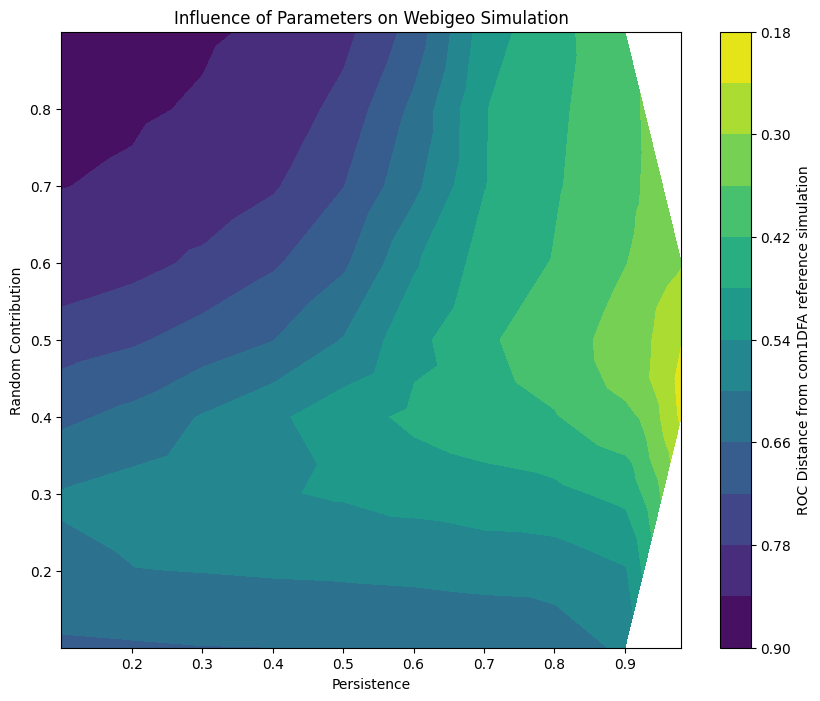

In [14]:
# Pivot the DataFrame to create a 2D grid for contour plotting
grid = df.pivot(index="random", columns="persistence", values="roc_distance")

# Extract x, y, and z values for plotting
x = grid.columns.values  # Unique x values
y = grid.index.values    # Unique y values
z = grid.values          # 2D array of z values

# Create the contour plot
fig, ax = plt.subplots(figsize=(10, 8))
# contour = plt.contourf(x, y, z, cmap="viridis_r", levels=10)
contour = plt.tricontourf(df["persistence"], df["random"], df["roc_distance"], cmap="viridis_r", levels=10)
cbar = plt.colorbar(contour, label="ROC Distance from com1DFA reference simulation")
cbar.ax.invert_yaxis()
ax.set(title="Influence of Parameters on Webigeo Simulation", xlabel="Persistence", ylabel="Random Contribution")
os.makedirs(webigeo_sim_dir / release_scenerio / "plots", exist_ok=True)
plt.savefig(webigeo_sim_dir / release_scenerio / "plots" / "webigeo_roc_distance.png", dpi=300)
print(webigeo_sim_dir / release_scenerio / "plots" / "webigeo_roc_distance.png")

c:\git\evaluation-utilities\webigeo_output\avaHelix_release1HX\bc7926_pers_0.00_rand_0.90_n_256_s_2048_a_25


C:\Users\magge\AppData\Local\Temp\ipykernel_34304\2831850138.py:239: RuntimeWarning: invalid value encountered in sqrt
  return np.nan_to_num(np.sqrt(clamped_pixel * 2 * 9.81))


c:\git\evaluation-utilities\webigeo_output\avaHelix_release1HX\6d5b46_pers_0.20_rand_0.40_n_256_s_2048_a_25
c:\git\evaluation-utilities\webigeo_output\avaHelix_release1HX\be1ac9_pers_0.10_rand_0.40_n_256_s_2048_a_25
c:\git\evaluation-utilities\webigeo_output\avaHelix_release1HX\5910a7_pers_0.30_rand_0.40_n_256_s_2048_a_25
c:\git\evaluation-utilities\webigeo_output\avaHelix_release1HX\3c8d52_pers_0.00_rand_0.40_n_256_s_2048_a_25


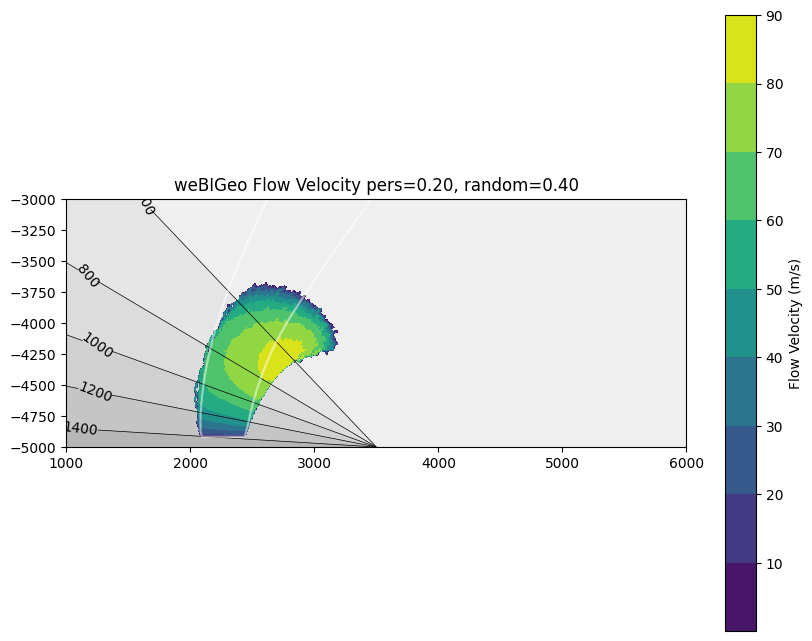

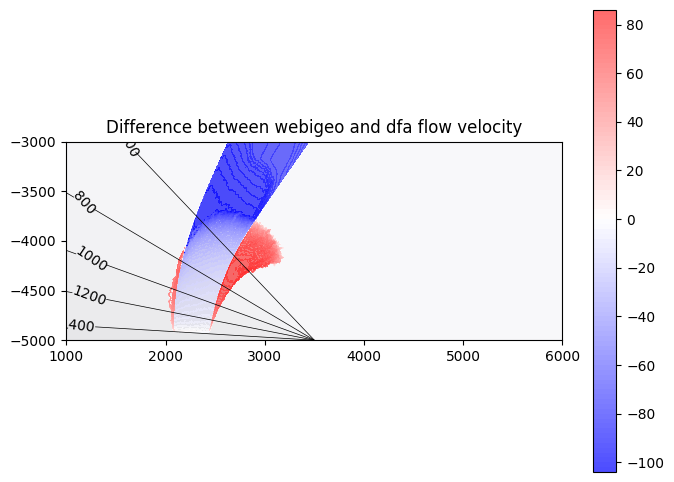

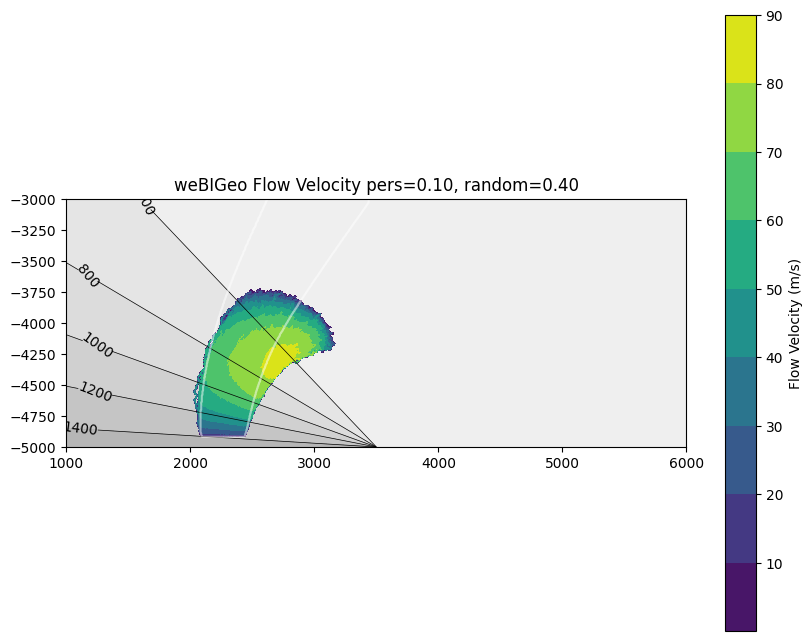

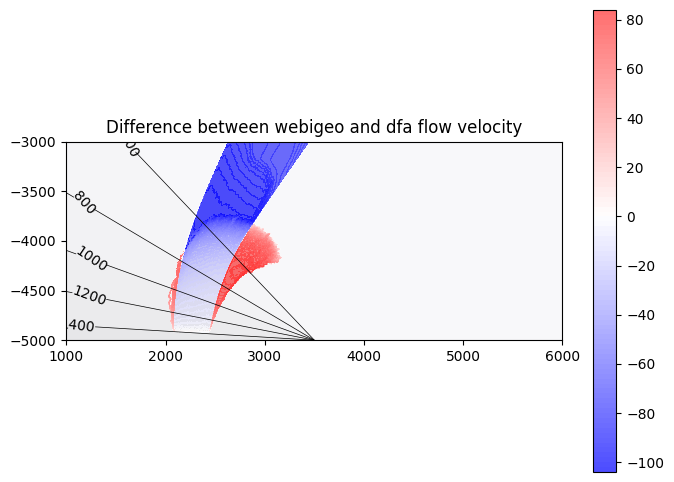

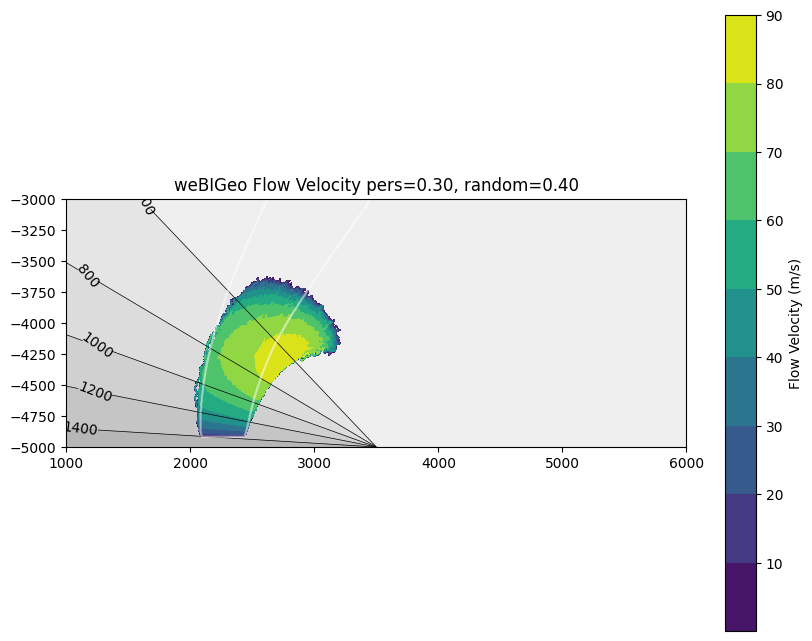

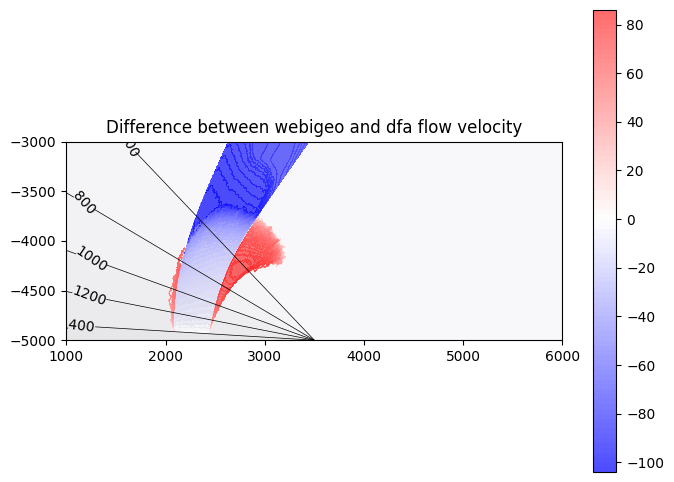

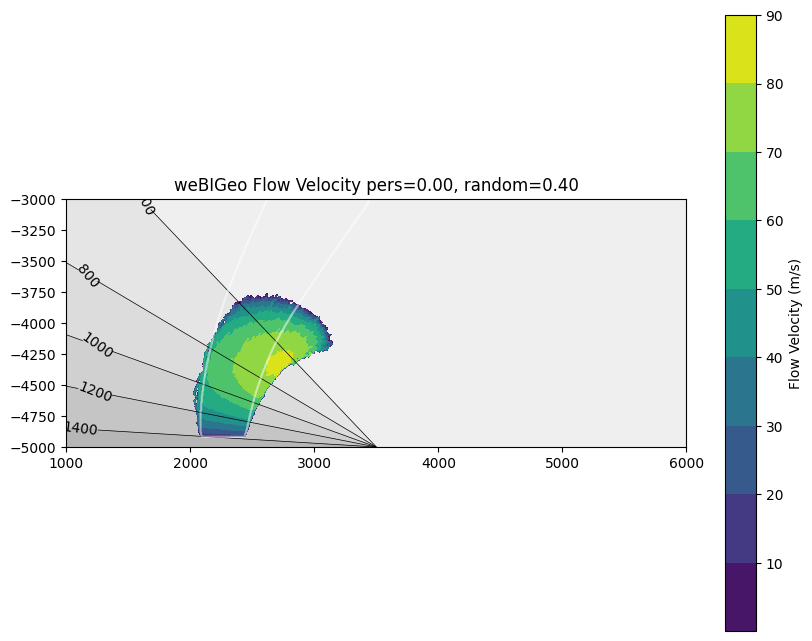

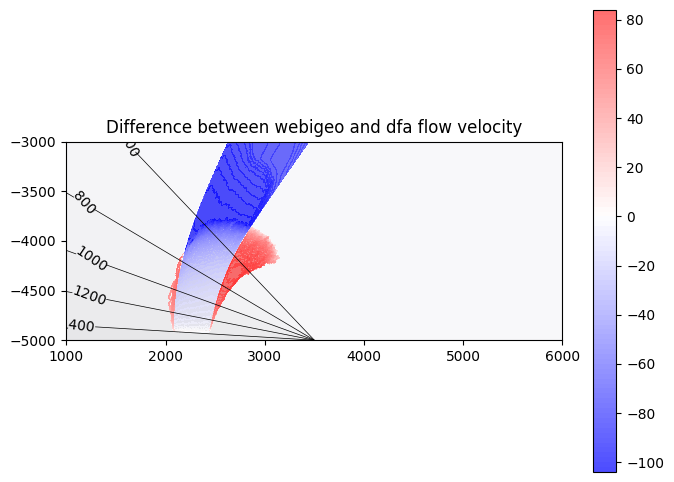

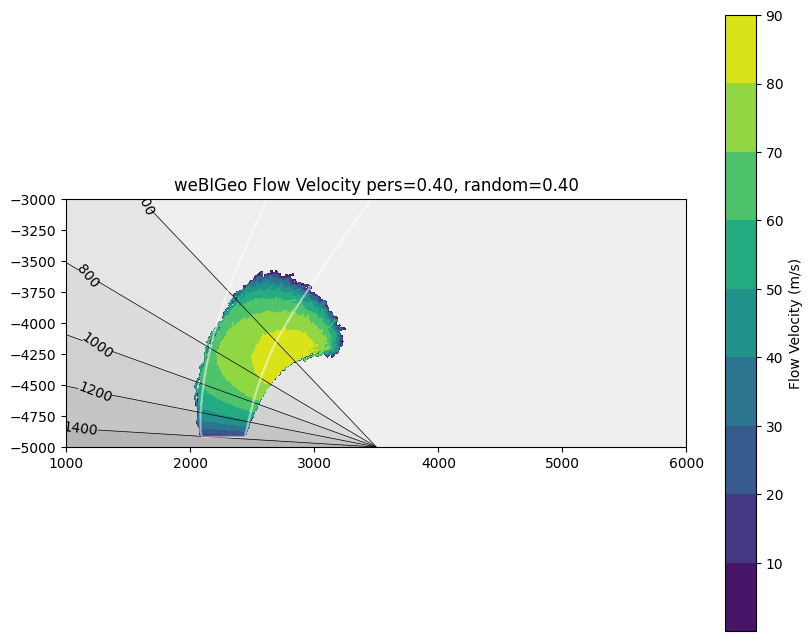

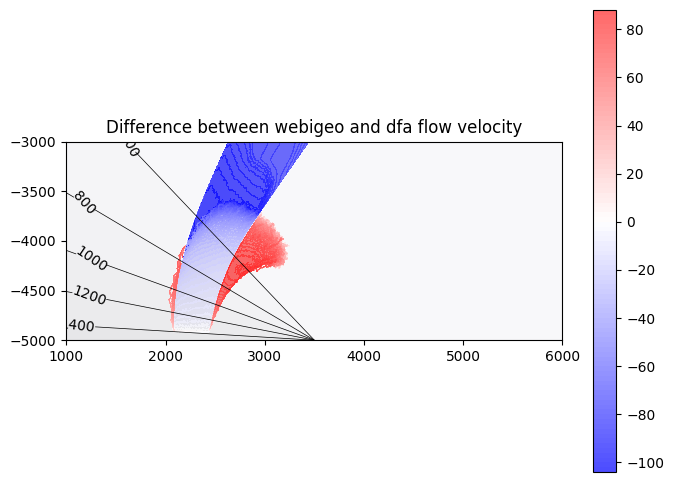

In [ ]:

    
for release_scenerio in release_scenerios:
    d = webigeo_output_dir / sim_case / release_scenerio
    sim_cases = os.listdir(d)
    shifted_dem_mask = np.ones_like(corrected_dem, dtype=bool)
    shifted_dem_mask_left = np.ones_like(corrected_dem, dtype=bool)
    shifted_dem_mask_right = np.ones_like(corrected_dem, dtype=bool)
    edge_distance = 3
    shifted_dem_mask_left[:, :-edge_distance] = np.isnan(corrected_dem)[:, edge_distance:]
    shifted_dem_mask_right[:, edge_distance:] = np.isnan(corrected_dem)[:, :-edge_distance]
    shifted_dem_mask = shifted_dem_mask_left | shifted_dem_mask_right

    for i, hash in enumerate(df.simHash[:5]):
            print(d / case)
            case = next((c for c in sim_cases if c.startswith(hash)))

            settings = json.load(open(d / case / "settings.json"))
            png_filename = d / case / r"trajectories\texture_layer1_zdelta.png"
            velocity = read_webigeo_flow_velocity(png_filename)
            velocity[shifted_dem_mask] = 0
            # velocity[velocity > 100] = np.nan
            fig, ax = plot_flow_velocity(velocity, corrected_dem, xx, yy, title=f"weBIGeo Flow Velocity pers={settings['persistence_contribution']:.2f}, random={settings['random_contribution']:.2f}");
            ax.contour(xx, yy, dfa_flow_velocity > 0, colors="white", alpha=0.5)
            os.makedirs(d / "plots", exist_ok=True)
            fig.savefig(d / "plots" / f"a{i:04}_{case}_flow_velocity.png", dpi=300)
            fig, ax = plot_flow_velocity_diff(velocity, dfa_flow_velocity, corrected_dem, xx, yy)
            fig.savefig(d / "plots" / f"d{i:04}_{case}_flow_velocity_diff.png", dpi=300)

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

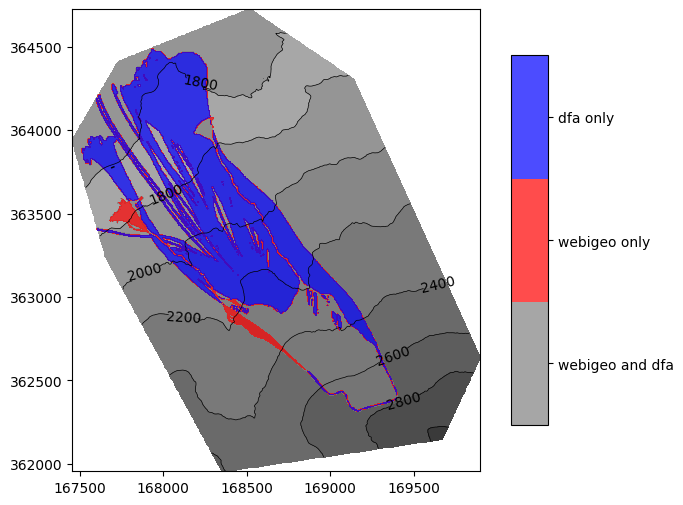

In [651]:

comparison = np.zeros_like(velocity, dtype=int)
only_dfa = ~(velocity > 0) & (dfa_flow_velocity > 0)
only_webigeo = (velocity > 0) & ~(dfa_flow_velocity > 0)
both = (velocity > 0) & (dfa_flow_velocity > 0)
array = np.zeros(x.shape, dtype=int)
comparison[both] = 1
comparison[only_webigeo] = 2
comparison[only_dfa] = 3
cmap = ListedColormap(['gray', 'red', 'blue'])  # White for False, Red for True

# Plot the boolean array as a contour plot
fig, ax = plt.subplots(figsize=(8, 6))

plot_dem(ax, corrected_dem, xx, yy)
cont = ax.contourf(xx, yy, comparison, cmap=cmap, levels=[0.5, 1.5, 2.5, 3.5], alpha=0.7)
cbar = fig.colorbar(cont, ax=ax, ticks=[0, 1, 2, 3], shrink=0.8, aspect=10)
cbar.ax.set_yticklabels(["No avalanche", "webigeo and dfa", "webigeo only", "dfa only"])
# cbar.set_label('Boolean Value')
ax.set_aspect('equal')
print

np.float64(-86.45870208740234)

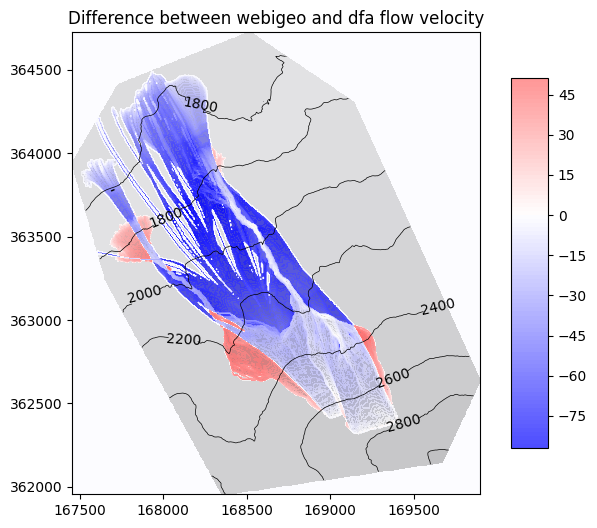

In [7]:
# plot com1DFA particles
import pickle

# Path to the pickle file
avaframe_output_dir
file_path = avaframe_output_dir / r"particles\particles_relWog_fcfa9c273d_C_L_null_dfa_0001.0000.pickle"
file_path = avaframe_output_dir / r"particles\particles_relWog_fcfa9c273d_C_L_null_dfa_0095.8000.pickle"
file_path = avaframe_output_dir / "particles" / [file for file in os.listdir(avaframe_output_dir / "particles") if file.endswith("0095.8000.pickle")][0]
# Unpickle the file
with open(file_path, "rb") as file:  # Open the file in binary read mode
    data = pickle.load(file)  # Deserialize the file content

# Print the unpickled data
print("Unpickled Data:")
print(data['dt'])
# plot_dem(ax, corrected_dem, xx, yy)
# fig, ax = plot_inputs(xx, yy, corrected_dem, release_areas)
# ax.plot(data["x"] + dem_header['xllcenter'], data["y"] + dem_header['yllcenter'], "r.", markersize=1)
# ax.set(xlim=(data["x"].min() + dem_header['xllcenter'], data["x"].max() + dem_header['xllcenter']), ylim=(data["y"].min() + dem_header['yllcenter'], data["y"].max() + dem_header['yllcenter']))
# ax.set(title="com1DFA Particles")
# number_particles = len(data["x"])
# print(f"Number of particles: {number_particles}")
file_path

Unpickled Data:
0.1


WindowsPath('C:/git/snow_avalanches/AvaFrame/avaframe/data/avaMal/Outputs/com1DFA/particles/particles_relMal1to3_8e9048922a_C_L_null_dfa_0095.8000.pickle')

In [39]:
area_sum = 0
for release in release_areas:
    path = release.get_path()
    vertices = path.vertices

    # Calculate the area using the Shoelace formula
    x = vertices[:, 0]
    y = vertices[:, 1]
    area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
    area_sum += area
print(f"Polygon Area: {area_sum:.0f} m²")
print(f"Particle density: {number_particles / area_sum:.2f} particles/m²")

Polygon Area: 348610 m²
Particle density: 0.20 particles/m²


In [40]:
25 / 256

0.09765625